In [1]:
import sys
import os

import torch
import random
import warnings
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import Convolve
from scipy.ndimage import gaussian_filter1d
from cca_zoo.linear import rCCA
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

# Import MI files
from utils import *
from models import *
from estimators import *
from trainers import *

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['figure.dpi'] = 100

# Set global font sizes for better readability
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.titlesize': 18})
plt.rcParams.update({'axes.labelsize': 16})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'legend.fontsize': 15})

# Directories
main_dir = os.getcwd()
model_cache_dir = os.path.join(main_dir, '..', 'model_cache')

# Set default type now
default_dtype = torch.float32
torch.set_default_dtype(default_dtype)

/Users/leo/Desktop/ResearchPhD/VNCMP/analysis_VNCMP/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# To-do list:
Main:
- [X] Test precision estimation
- [] Re-write inference to do batches above a certain size
- [] Compare performance to running with mini-batched dataloader (rather than rolling mini-batches myself in forward method)
- [] Implement precision functions


Low priority:
- [] Try ISI encoding instead (as in https://pmc.ncbi.nlm.nih.gov/articles/PMC9870156/)
- [/] Parallel training with shared memory, fixed to have the right number of processes


In [2]:
# Check if CUDA or MPS is running
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = "CPU"

print(f'Device: {device}')

Device: mps


0.12495088577270508
Neurons (X): torch.Size([32, 3876107])
Muscles (Y): torch.Size([10, 3876107])
Neuron Labels: ['87', '29', '1', '78', '12', '20', '2', '6', '41', '11', '13', '65', '89', '15', '75', '42', '33', '28', '14', '39', '21', '7', '96', '68', '8', '88', '93', '26', '10', '0', '30', '3']
Muscle Labels: ['rsa', 'rdvm', 'lba', 'ldvm', 'rdlm', 'lsa', 'rax', 'lax', 'rba', 'ldlm']


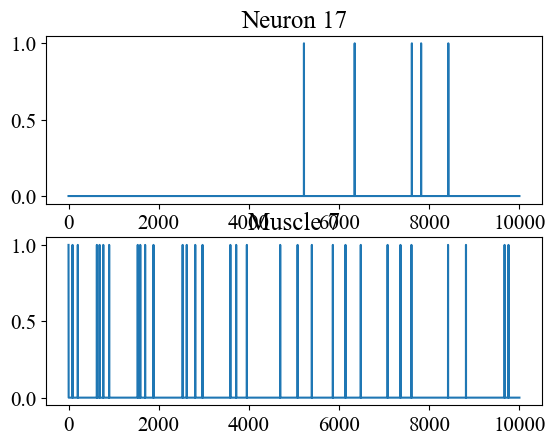

In [3]:
# Read the data and apply some binning/downsampling
data_dir = os.path.join(os.getcwd(), '..', '..', 'localdata', 'data_for_python')

period = 0.0001
tic = time.time()
X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
# Convert to torch tensors
X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)
print(time.time() - tic)

print(f"Neurons (X): {X.shape}")
print(f"Muscles (Y): {Y.shape}") 
print("Neuron Labels:", x_labels)
print("Muscle Labels:", y_labels)

# Plot sample of activity
pl = 10000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
idx = torch.nonzero(Y[usemuscle,:] > 0)[0][0]
fig, ax = plt.subplots(2, 1)
ax[0].plot(X[useneuron,idx:idx+pl])
ax[1].plot(Y[usemuscle,idx:idx+pl])
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

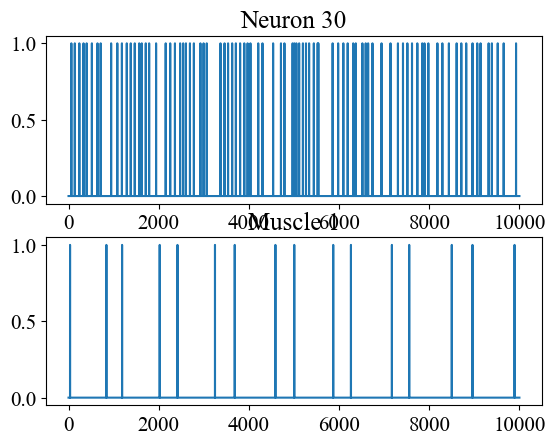

In [71]:
pl = 10000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
# useneuron = 20
idx = np.random.choice(torch.nonzero(Y[usemuscle,:] > 0)[0])#[0]
fig, ax = plt.subplots(2, 1)
idx = idx + 4000
ax[0].plot(X[useneuron,idx:idx+pl])
ax[1].plot(Y[usemuscle,idx:idx+pl])
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

In [57]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 512, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'n_trials': 3,
    'patience': 30,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'Nx': X.shape[0],
    'Ny': Y.shape[0],
    'layers': 4,
    'fc_layers': 2, # fully connected layers, only for if using CNNs from data_form: 'image' 
    'hidden_dim': 512,
    'activation': nn.LeakyReLU, #nn.Softplus
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'data_form': 'image',
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 1000, # If input has more than this many batches, encoder runs are split up for memory management
}

In [58]:
torch.mps.empty_cache()
neuron = np.random.choice(X.shape[0])
print(f'Neuron {neuron}')
this_params = {**params, 'embed_dim': 10, 'window_size': 256}
dataset = BatchedDataset(X[[neuron],:].to(device), Y.to(device), this_params['window_size'])
mis, mis_test, mod = train_cnn_model(DSIB, dataset, this_params)

Neuron 13
Train time = 5.233349084854126
Eval time = 0.2539498805999756
Test time = 0.2555258274078369
Epoch: 1, DSIB, train: 0.003320095594972372, test: 0.001765341148711741
Train time = 4.165913105010986
Eval time = 0.10607004165649414
Test time = 0.10607099533081055
Epoch: 2, DSIB, train: 0.005599518306553364, test: 0.005412778351455927
Train time = 4.197257995605469
Eval time = 0.10527420043945312
Test time = 0.10547399520874023
Epoch: 3, DSIB, train: 0.010158253833651543, test: 0.005208139307796955
Train time = 4.180523157119751
Eval time = 0.1056210994720459
Test time = 0.10546708106994629
Epoch: 4, DSIB, train: 0.01254495419561863, test: 0.009589197114109993
Train time = 4.171719074249268
Eval time = 0.1058950424194336
Test time = 0.1055450439453125
Epoch: 5, DSIB, train: 0.05102319270372391, test: 0.040515780448913574
Train time = 4.204957962036133
Eval time = 0.10549402236938477
Test time = 0.10550093650817871
Epoch: 6, DSIB, train: 0.06049139425158501, test: 0.044782239943742

(0.0, 0.23757375832647085)

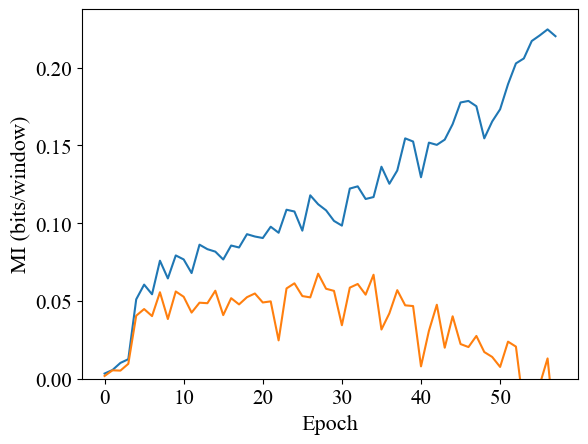

In [59]:
sigma = 1
plt.plot(mis)
plt.plot(mis_test)
# plt.plot(gaussian_filter1d(mis, sigma=sigma) * np.log2(np.e) / (0.0005 * 512))
# plt.plot(gaussian_filter1d(mis_test, sigma=sigma) * np.log2(np.e) / (0.0005 * 512))
plt.xlabel('Epoch')
plt.ylabel('MI (bits/window)')
plt.ylim(0)

(0.0, 1.0907957222162623)

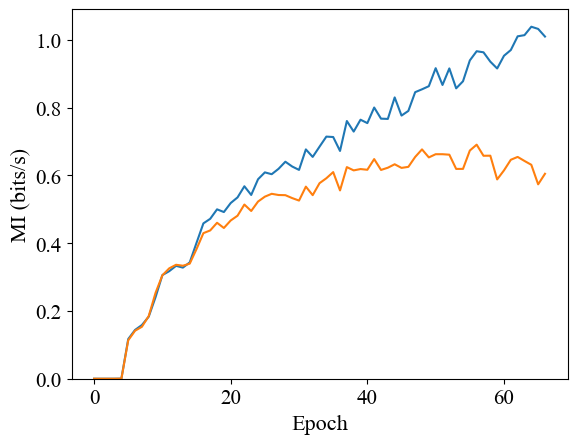

In [ ]:
sigma = 1
plt.plot(mis)
plt.plot(mis_test)
# plt.plot(gaussian_filter1d(mis, sigma=sigma) * np.log2(np.e) / (0.0005 * 512))
# plt.plot(gaussian_filter1d(mis_test, sigma=sigma) * np.log2(np.e) / (0.0005 * 512))
plt.xlabel('Epoch')
plt.ylabel('MI (bits/window)')
plt.ylim(0)

# Precision



Saturday:
- Clean, integrate kinematics data
- Upload data to PACE, test interactive session to see how 

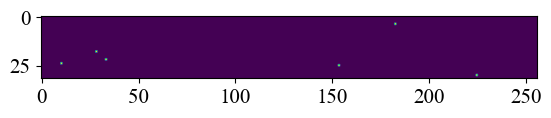

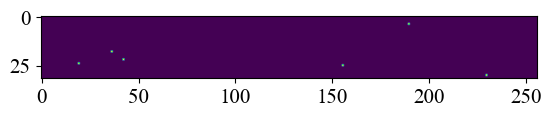

In [64]:
this_params = {**params, 'embed_dim': 10, 'batch_size': 256}
dataset = BatchedDatasetWithNoise(X.to(device), Y.to(device), this_params['batch_size'])

plt.figure()
dataset.apply_noise(0)
plt.imshow(dataset.Xnoise[0,0,:,:].cpu())
plt.figure()
dataset.apply_noise(0.001 / period)
plt.imshow(dataset.Xnoise[0,0,:,:].cpu())

In [ ]:
torch.cuda.empty_cache()
mod.eval()
amts = np.linspace(100,1500,10, dtype=int)
vals = np.zeros_like(amts)
with torch.no_grad():
    for i,amt in enumerate(amts):
        dataset.apply_noise(0)
        inds = np.random.choice(np.arange(dataset.Xnoise.shape[0]), amt)
        vals[i] = - mod(dataset.Xnoise[inds,:,:,:], dataset.Ynoise[inds,:,:,:])
plt.plot(amts, vals)

In [8]:
torch.mps.empty_cache()

# this_params = {**params, 'embed_dim': 10, 'window_size': 256}
torch.mps.synchronize()
tic = time.time()
dataset = BatchedDatasetWithNoise(X.to(device), Y.to(device), this_params['window_size'])
torch.mps.synchronize()
print(f'dataset = {time.time() - tic}')

n_repeats = 3
# noise_levels = torch.arange(period, 20*period, step=period).to(device)
noise_levels = torch.logspace(np.log10(period), np.log10(0.02), 20).to(device)
precision_mi = torch.zeros((len(noise_levels), n_repeats)).to(device)

mod.eval()

with torch.no_grad():
    for i,amp in enumerate(noise_levels):
        for j in range(n_repeats):
            dataset.apply_noise(amp / period)

            # inds = np.random.choice(np.arange(dataset.Xnoise.shape[0]), 2000)
            torch.mps.synchronize()
            tic = time.time()
            precision_mi[i,j] = -models[0](dataset.Xnoise, dataset.Ynoise).detach()
            torch.mps.synchronize()
            print(f'Inference: {time.time() - tic}')


dataset = 0.15633583068847656
Inference: 0.5941340923309326
Inference: 0.6205008029937744
Inference: 0.5042769908905029
Inference: 0.49620890617370605
Inference: 0.49607014656066895
Inference: 0.49566197395324707
Inference: 0.5053088665008545
Inference: 0.5037403106689453
Inference: 0.49646592140197754
Inference: 0.5309922695159912
Inference: 0.5017919540405273
Inference: 0.5031547546386719
Inference: 0.5056519508361816
Inference: 0.5065462589263916
Inference: 0.5328259468078613
Inference: 0.5059599876403809
Inference: 0.5154757499694824
Inference: 0.5013079643249512
Inference: 0.4972820281982422
Inference: 0.49623584747314453
Inference: 0.49387693405151367
Inference: 0.4951040744781494
Inference: 0.5004711151123047
Inference: 0.49389219284057617
Inference: 0.5356400012969971
Inference: 0.5194571018218994
Inference: 0.5167787075042725
Inference: 0.5145699977874756
Inference: 0.5240731239318848
Inference: 0.5170049667358398
Inference: 0.51226806640625
Inference: 0.5134811401367188
Infer

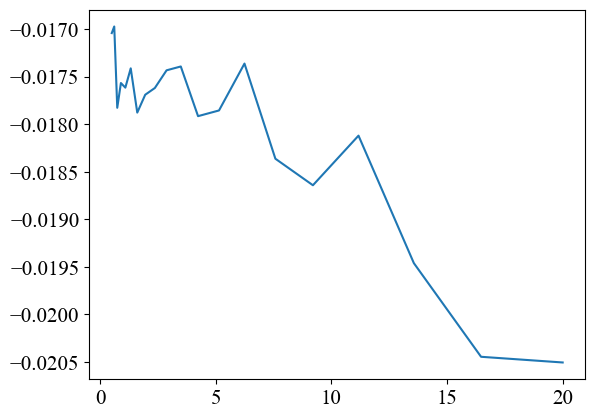

In [9]:
plt.plot(noise_levels.cpu() * 1000, torch.mean(precision_mi, dim=1).cpu())
# plt.gca().set_xscale('log')

# Precision estimation via training (not inference)

Re-training the model with different amounts of noise applied to the data

In [4]:
def train_cnn_model_no_eval_apply_noise(model_func, full_dataset, params, model_save_dir, noise_amp, device=device):
    """
    Generalized training function for DSIB and DVSIB models with early stopping.
    Version that does not run evaluation! Skimps on that to save time, returns only mi values from test
    Args:
        model: The model to train (DSIB or DVSIB).
        data: Tuple of (train, test, eval) dataloaders. 
            Assumes uses BatchSubsetDataset with custom sampler
            Assumes loaders return X, Y of shapes (M_x, N) and (M_y, N)
    Returns:
        An array test_estimates containing mutual information estimates of TEST SET ONLY
    """
    # Initialize model
    model_name = model_func.__name__
    model = model_func(params)
    model.to(device)  # Ensure model is on GPU
    # Make save directory if it doesn't exist, generate unique model id
    os.makedirs(model_save_dir, exist_ok=True)
    train_id = model_name + '_' + f'dz-{params["embed_dim"]}_' + f'bs-{params["window_size"]}_' + str(uuid.uuid4())
    # Create training dataloader, get indices for test set
    train_loader, test_indices, _ = create_cnn_data_split(full_dataset, params['batch_size'], params['train_fraction'])
    test_X, test_Y = full_dataset.Xnoise[test_indices,:,:,:], full_dataset.Ynoise[test_indices,:,:,:]
    # Initialize variables
    epochs = params['epochs']
    opt = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], eps=params['eps'])
    estimates_mi_test = []
    best_estimator_ts = float('-inf')  # Initialize with negative infinity
    no_improvement_count = 0
    for epoch in range(epochs):
        full_dataset.apply_noise(noise_amp)
        torch.mps.synchronize()
        start = time.time()
        for i, (x, y) in enumerate(iter(train_loader)):
            opt.zero_grad()
            # Compute loss based on model type
            if model_name == "DSIB":
                loss = model(x, y)  # DSIB returns a single loss
            elif model_name == "DVSIB":
                loss, _, _ = model(x, y)  # DVSIB returns three outputs
            else:
                raise ValueError("Invalid model_type. Choose 'DSIB' or 'DVSIB'.")
            loss.backward()
            opt.step()
        torch.mps.synchronize()
        print(f'Train time = {time.time() - start}')
        # Test model at every epoch
        with torch.no_grad():
            if model_name == "DSIB":
                torch.mps.synchronize()
                start = time.time()
                estimator_ts = -model(test_X, test_Y)
                torch.mps.synchronize()
                print(f'Test time = {time.time() - start}')
            elif model_name == "DVSIB": # Get lossGout, that is the mi value
                _, _, estimator_ts = model(test_X, test_Y)
            estimator_ts = estimator_ts.to('cpu').detach().numpy()
            estimates_mi_test.append(estimator_ts)
        print(f"Epoch: {epoch+1}, {model_name}, test: {estimator_ts}", flush=True)
        # Save snapshot of model
        torch.save(
            model, 
            os.path.join(model_save_dir, f'epoch{epoch}_' + train_id + '.pt')
        )
        # Check for improvement, negative values, or nans
        if np.isnan(estimator_ts):
            print('Early stop due to nan outputs')
            break
        if estimator_ts < 0:
            no_improvement_count += 1
        elif estimator_ts > best_estimator_ts + params['min_delta']:
            # We have an improvement
            best_estimator_ts = estimator_ts
            no_improvement_count = 0
        else:
            # No significant improvement
            no_improvement_count += 1
        # Check if we should stop early
        if no_improvement_count >= params['patience']:
            print(f"Early stopping triggered after {epoch+1} epochs. Best estimator_ts: {best_estimator_ts}")
            break
    return np.array(estimates_mi_test), train_id

In [43]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 256, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 1e-3,
    'n_trials': 3,
    'patience': 30,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'Nx': X.shape[0],
    'Ny': Y.shape[0],
    'layers': 5,
    'fc_layers': 2, # fully connected layers, only for if using CNNs from data_form: 'image' 
    'hidden_dim': 512,
    'activation': nn.LeakyReLU, #nn.Softplus
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'data_form': 'image',
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 1000, # If input has more than this many batches, encoder runs are split up for memory management
}

neuron = 30

period = 0.0005
noise_range = np.hstack((0, np.logspace(np.log10(period), np.log10(0.01), 10) / period))
mi = np.zeros_like(np.array(noise_range))
mi_test = []
models = []
ids = []
# Precision curve params
precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 40) / period))
n_repeats = 5
precision_curves = []

X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)

for i,noise_amp in enumerate(noise_range):
    torch.mps.empty_cache()
    this_params = {**params, 'embed_dim': 10}
    dataset = BatchedDatasetWithNoise(X[[neuron],:].to(device), Y.to(device), this_params['window_size'])
    mis_test, train_id = train_cnn_model_no_eval_apply_noise(DSIB, dataset, this_params, model_cache_dir, noise_amp)
    mod = retrieve_best_model(model_cache_dir, mis_test, train_id=train_id, burn_in=1)
    # Store results
    mi_test.append(mis_test)
    models.append(mod)
    ids.append(train_id)
    # Run inference
    with torch.no_grad():
        dataset.apply_noise(noise_amp)
        thismi = - mod(dataset.Xnoise, dataset.Ynoise)
        mi[i] = thismi.detach().cpu()
        # Precision curve for each 
        precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
        for j0,prec_noise_amp in enumerate(precision_noise_levels):
            for j1 in range(n_repeats):
                dataset.apply_noise(prec_noise_amp)
                precision_mi[j0,j1] = - mod(dataset.Xnoise, dataset.Ynoise).detach().cpu().numpy()
        precision_curves.append(precision_mi)


Train time = 1.258162021636963
Test time = 0.15600109100341797
Epoch: 1, DSIB, test: 0.07263732701539993
Train time = 1.2500531673431396
Test time = 0.04039907455444336
Epoch: 2, DSIB, test: 0.1351468414068222
Train time = 1.241243839263916
Test time = 0.040470123291015625
Epoch: 3, DSIB, test: 0.2149248719215393
Train time = 1.243453025817871
Test time = 0.04035210609436035
Epoch: 4, DSIB, test: 0.16363148391246796
Train time = 1.2439327239990234
Test time = 0.04240608215332031
Epoch: 5, DSIB, test: 0.14411666989326477
Train time = 1.2416210174560547
Test time = 0.041394948959350586
Epoch: 6, DSIB, test: 0.08690782636404037
Train time = 1.242805004119873
Test time = 0.04032087326049805
Epoch: 7, DSIB, test: -0.07231641560792923
Train time = 1.2425096035003662
Test time = 0.04041600227355957
Epoch: 8, DSIB, test: -0.19522608816623688
Train time = 1.237919807434082
Test time = 0.04030013084411621
Epoch: 9, DSIB, test: -0.7326962351799011
Train time = 1.2354371547698975
Test time = 0.039

Text(0, 0.5, 'MI (bits/s)')

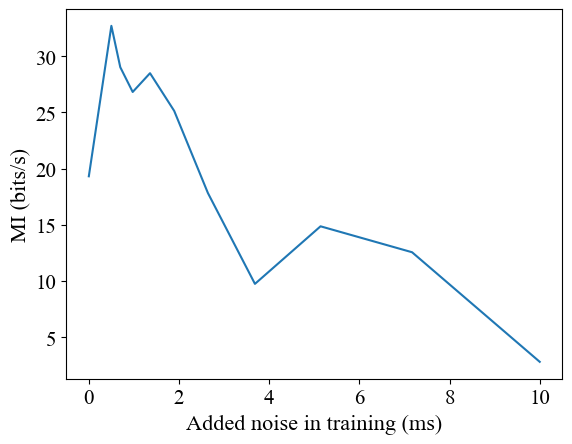

In [48]:
torch.mps.empty_cache()
plt.plot(noise_range * period * 1000, mi * np.log2(np.e) / params['window_size'] / period)
plt.gca().set_xlabel('Added noise in training (ms)')
plt.gca().set_ylabel('MI (bits/s)')

Text(0, 0.5, 'Measured precision (ms)')

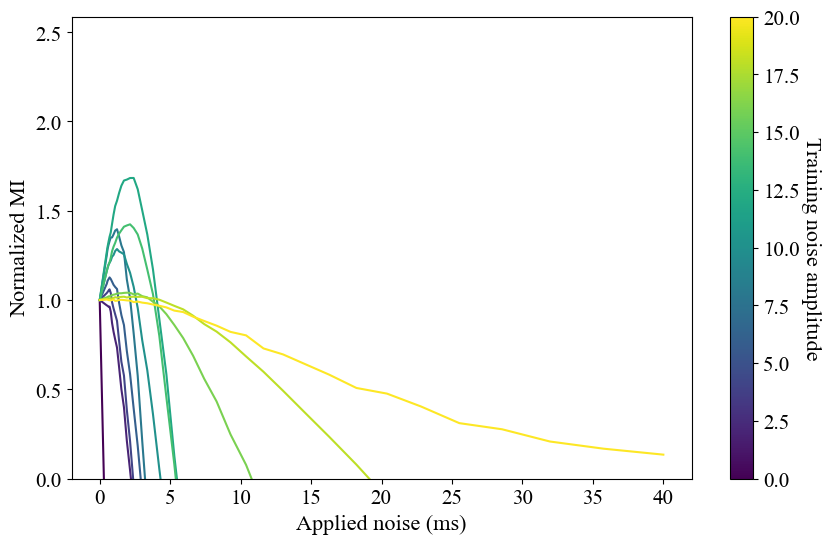

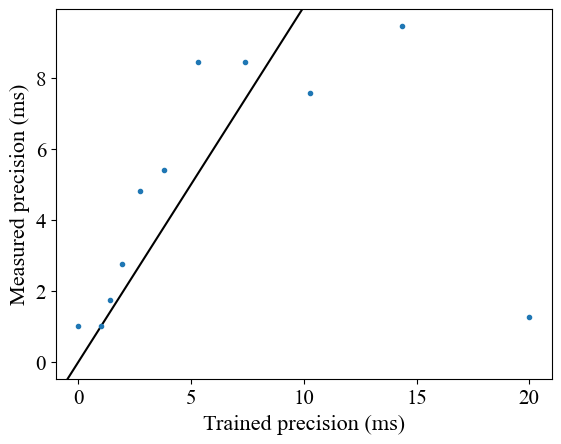

In [62]:
fig, ax = plt.subplots(figsize=(10, 6))
cmap = plt.cm.get_cmap('viridis')
for i in range(len(noise_range)):
    color_pos = i / (len(noise_range) - 1) if len(noise_range) > 1 else 0
    color = cmap(color_pos)
    vals = np.mean(precision_curves[i], axis=1) * np.log2(np.e) / params['window_size'] / period
    ax.plot(precision_noise_levels * period * 1000, vals / vals[0], color=color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=noise_range[-1]))
sm.set_array([])  # Required for ScalarMappable
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Training noise amplitude', rotation=270, labelpad=15)
ax.set_ylim(0)
ax.set_xlabel('Applied noise (ms)')
ax.set_ylabel('Normalized MI')

fig, ax = plt.subplots()
precision = []
for curve in precision_curves:
    val = np.mean(curve, axis=1)
    val = val / val[0]
    precision.append(precision_noise_levels[np.argmax(val < 1)])

ax.axline([0,0], slope=1, color='k')
ax.plot(noise_range, np.array(precision),'.')
ax.set_xlabel('Trained precision (ms)')
ax.set_ylabel('Measured precision (ms)')

# Vary dataset binning, see how it changes information learned/found

In [ ]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 256, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'n_trials': 3,
    'patience': 30,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'Nx': X.shape[0],
    'Ny': Y.shape[0],
    'layers': 4,
    'fc_layers': 2, # fully connected layers, only for if using CNNs from data_form: 'image' 
    'hidden_dim': 512,
    'activation': nn.LeakyReLU, #nn.Softplus
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'data_form': 'image',
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 1000, # If input has more than this many batches, encoder runs are split up for memory management
}

neuron = 30

# period_range = [0.0001, 0.0005, 0.001, 0.005]
period_range = np.logspace(np.log10(0.0001), np.log10(0.01), 10)
mi_test = []
models = []
ids = []

for period in period_range:
    print(f'Period = {period} s')
    X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
    X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)
    torch.mps.empty_cache()
    this_params = {**params, 'embed_dim': 10}
    dataset = BatchedDataset(X[[neuron],:].to(device), Y.to(device), this_params['window_size'])
    mis_test, train_id = train_cnn_model_no_eval(DSIB, dataset, this_params, model_cache_dir)
    mod = retrieve_best_model(model_cache_dir, mis_test, train_id=train_id, burn_in=1)
    # Store results
    mi_test.append(mis_test)
    models.append(mod)
    ids.append(train_id)

# Inference on best model for each dataset
mi = np.zeros_like(np.array(period_range))
with torch.no_grad():
    for i,period in enumerate(period_range):
        torch.mps.empty_cache()
        X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
        X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)
        this_params = {**params, 'embed_dim': 10}
        dataset = BatchedDataset(X[[neuron],:].to(device), Y.to(device), this_params['window_size'])
        thismi = - models[i](dataset.X, dataset.Y)
        mi[i] = thismi.detach().cpu()


Text(0, 0.5, 'MI (bits/s)')

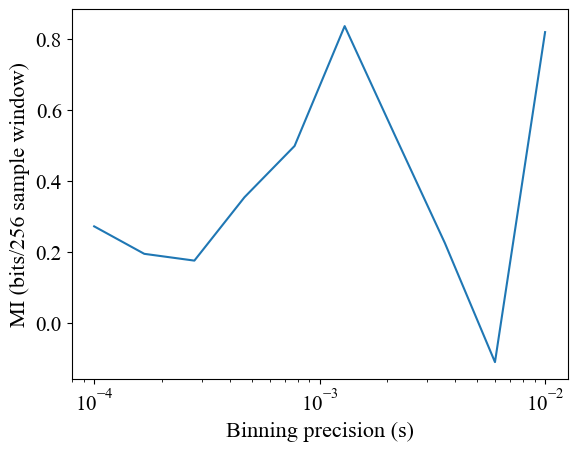

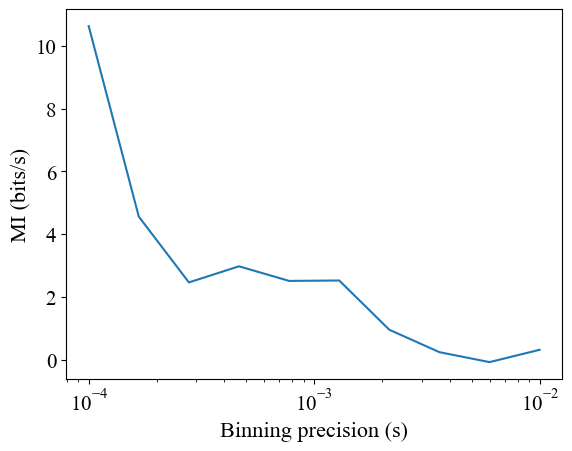

In [19]:
plt.plot(np.array(period_range), mi * np.log2(np.e))# / 256 / period_range)
ax = plt.gca()
ax.set_xscale('log')
ax.set_xlabel('Binning precision (s)')
ax.set_ylabel('MI (bits/256 sample window)')

plt.figure()
plt.plot(np.array(period_range), mi * np.log2(np.e) / 256 / period_range)
ax = plt.gca()
ax.set_xscale('log')
ax.set_xlabel('Binning precision (s)')
ax.set_ylabel('MI (bits/s)')

# Does batch size matter, all else being equal?

In [32]:
# Vary batch size, nothing else
mib = {}
mib_test = {}
batch_size_range = np.array([20, 40, 60, 80, 100], int)
dz = 10
windowsize = 128

for bs in batch_size_range:
    this_params = {**params, 'embed_dim': dz, 'batch_size': windowsize, 'patience': 30}
    print(f'Batch size = {bs}')
    torch.cuda.empty_cache()
    dataset = BatchedDataset(X, Y, this_params['batch_size'])
    full_dataset = create_cnn_data_split(dataset, int(bs), train_fraction=0.9, eval_fraction=0.9, device=device)
    mis, mis_test, _ = train_cnn_model(DSIB, full_dataset, this_params)
    # Store results
    key = bs
    mib[key] = mis
    mib_test[key] = mis_test
torch.cuda.empty_cache()

Batch size = 20
Train time = 1.881711483001709
Eval time = 0.48735785484313965
Test time = 0.006005764007568359
Epoch: 1, DSIB, train: -0.0027641174383461475, test: -0.0039375536143779755
Train time = 1.6298112869262695
Eval time = 0.0020029544830322266
Test time = 0.001001119613647461
Epoch: 2, DSIB, train: 0.0014904411509633064, test: 0.0016972596058622003
Train time = 1.5781817436218262
Eval time = 0.002003192901611328
Test time = 0.0010008811950683594
Epoch: 3, DSIB, train: 0.000641500751953572, test: 0.0004749913641717285
Train time = 1.6044585704803467
Eval time = 0.0010008811950683594
Test time = 0.0020020008087158203
Epoch: 4, DSIB, train: -0.00023532789782620966, test: -4.940722533319786e-07
Train time = 1.5714285373687744
Eval time = 0.0020029544830322266
Test time = 0.0010004043579101562
Epoch: 5, DSIB, train: 0.008512355387210846, test: 0.009476181119680405
Train time = 1.6194770336151123
Eval time = 0.002002716064453125
Test time = 0.0020012855529785156
Epoch: 6, DSIB, tra

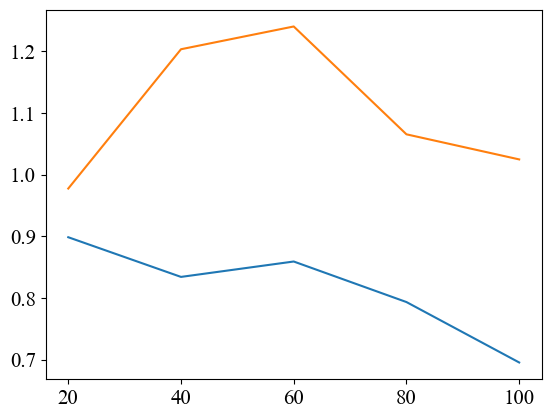

In [33]:
batch_size_range = np.array([20, 40, 60, 80, 100], int)
plt.figure()
mi_vals, mi_test_vals = [], [] 
for bs in batch_size_range:
    test = gaussian_filter1d(np.nan_to_num(mib_test[bs]), sigma=1)
    mi_vals.append(mib[bs][np.argmax(test)])
    mi_test_vals.append(mib_test[bs][np.argmax(test)])
plt.plot(batch_size_range, np.array(mi_test_vals))
plt.plot(batch_size_range, np.array(mi_vals))

In [26]:
from tqdm.auto import tqdm
# Empty arrays and do the run, will take forever
mi = {}
mi_test = {}
models = {}
ids = {}
batch_size_range = np.array([128, 256, 512, 1024])
neuron = np.random.choice(X.shape[0])

for bs in batch_size_range:
    for dz in tqdm(range(1, params['max_dz']+1)):
        print(f'Starting dz = {dz}')
        for j in range(params['n_trials']):
            this_params = {**params, 'embed_dim': dz, 'batch_size': bs}
            print(f'batch size = {bs}, dz = {dz}, trial = {j+1}')
            torch.cuda.empty_cache()
            dataset = BatchedDataset(X[[neuron],:], Y, this_params['batch_size'])
            full_dataset = create_cnn_data_split(dataset, 60, train_fraction=0.9, eval_fraction=0.9, device=device)
            mis, mis_test, _ = train_cnn_model(DSIB, full_dataset, this_params)
            # full_dataset = create_cnn_data_split(dataset, train_fraction=0.9, eval_fraction=0.9, device=device)
            # mis, mis_test = train_model(DSIB, full_dataset, this_params)
            # mis_test, train_id = train_model_no_eval(DSIB, full_dataset, this_params, model_cache_dir)
            # mod = retrieve_best_model(model_cache_dir, mis_test, train_id=train_id, burn_in=1)
            # Store results
            key = f"trial_{j}_dz_{dz}_bs_{bs}"
            mi[key] = mis
            mi_test[key] = mis_test
            # models[key] = mod
            # ids[key] = train_id
torch.cuda.empty_cache()


  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 128, dz = 1, trial = 1
Train time = 0.7406737804412842
Eval time = 0.016013622283935547
Test time = 0.005005598068237305
Epoch: 1, DSIB, train: -8.574826097174082e-06, test: -8.78915216162568e-06
Train time = 0.5104649066925049
Eval time = 0.002001047134399414
Test time = 0.002002716064453125
Epoch: 2, DSIB, train: -3.644090156740276e-06, test: -3.7664101455447963e-06
Train time = 0.5234763622283936
Eval time = 0.002001523971557617
Test time = 0.002003192901611328
Epoch: 3, DSIB, train: -1.7990419109992217e-06, test: -2.378149929427309e-06
Train time = 0.5004549026489258
Eval time = 0.002001523971557617
Test time = 0.002003192901611328
Epoch: 4, DSIB, train: -1.598914082023839e-06, test: -1.5391580063806032e-06
Train time = 0.5214755535125732
Eval time = 0.002002716064453125
Test time = 0.001001119613647461
Epoch: 5, DSIB, train: -8.14888323930063e-07, test: -1.0640453638188774e-06
Train time = 0.5054595470428467
Eval time = 0.002002716064453125
Test time =

  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 256, dz = 1, trial = 1
Train time = 0.43439412117004395
Eval time = 0.01401376724243164
Test time = 0.005004405975341797
Epoch: 1, DSIB, train: -0.00040275955689139664, test: -0.00039908778853714466
Train time = 0.45641469955444336
Eval time = 0.002002239227294922
Test time = 0.0009999275207519531
Epoch: 2, DSIB, train: -2.252435115224216e-05, test: -2.9693497708649375e-05
Train time = 0.4253857135772705
Eval time = 0.0020024776458740234
Test time = 0.002001047134399414
Epoch: 3, DSIB, train: -3.789873744608485e-06, test: -5.052479991718428e-06
Train time = 0.42738842964172363
Eval time = 0.0020017623901367188
Test time = 0.003002643585205078
Epoch: 4, DSIB, train: -1.6487376797158504e-06, test: -1.6182557374122553e-06
Train time = 0.4263877868652344
Eval time = 0.002187490463256836
Test time = 0.0010008811950683594
Epoch: 5, DSIB, train: -1.8684459064388648e-06, test: -1.3424544249573955e-06
Train time = 0.4133765697479248
Eval time = 0.002000570297241211


  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 512, dz = 1, trial = 1
Train time = 0.6295723915100098
Eval time = 0.016015052795410156
Test time = 0.007005929946899414
Epoch: 1, DSIB, train: -0.01148455310612917, test: -0.01034874189645052
Train time = 0.6191556453704834
Eval time = 0.0030028820037841797
Test time = 0.0020017623901367188
Epoch: 2, DSIB, train: -0.00048147584311664104, test: -0.00042977623525075614
Train time = 0.6265697479248047
Eval time = 0.0020020008087158203
Test time = 0.0010004043579101562
Epoch: 3, DSIB, train: -6.341320113278925e-05, test: -6.500879680970684e-05
Train time = 0.6385796070098877
Eval time = 0.0020020008087158203
Test time = 0.0020020008087158203
Epoch: 4, DSIB, train: -1.6865586076164618e-05, test: -1.9105924366158433e-05
Train time = 0.6155598163604736
Eval time = 0.002002239227294922
Test time = 0.0020017623901367188
Epoch: 5, DSIB, train: -1.0816255780810025e-05, test: -1.3565530025516637e-05
Train time = 0.6215651035308838
Eval time = 0.0020024776458740234
Tes

  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 1024, dz = 1, trial = 1
Train time = 0.5445020198822021
Eval time = 0.020017385482788086
Test time = 0.00600433349609375
Epoch: 1, DSIB, train: -0.012846967205405235, test: -0.01035755593329668
Train time = 0.5034575462341309
Eval time = 0.0020012855529785156
Test time = 0.002001523971557617
Epoch: 2, DSIB, train: -0.005014576483517885, test: -0.00434390502050519
Train time = 0.5044593811035156
Eval time = 0.0030014514923095703
Test time = 0.002002716064453125
Epoch: 3, DSIB, train: -0.0008515996159985662, test: -0.0006777612725272775
Train time = 0.5054595470428467
Eval time = 0.0020017623901367188
Test time = 0.002001523971557617
Epoch: 4, DSIB, train: -8.7614098447375e-05, test: -7.642570562893525e-05
Train time = 0.5024571418762207
Eval time = 0.0020017623901367188
Test time = 0.001001119613647461
Epoch: 5, DSIB, train: -5.419558874564245e-06, test: -4.655436441680649e-06
Train time = 0.5024561882019043
Eval time = 0.002001523971557617
Test time = 0.002

KeyError: 'trial_0_dz_1_bs_20'

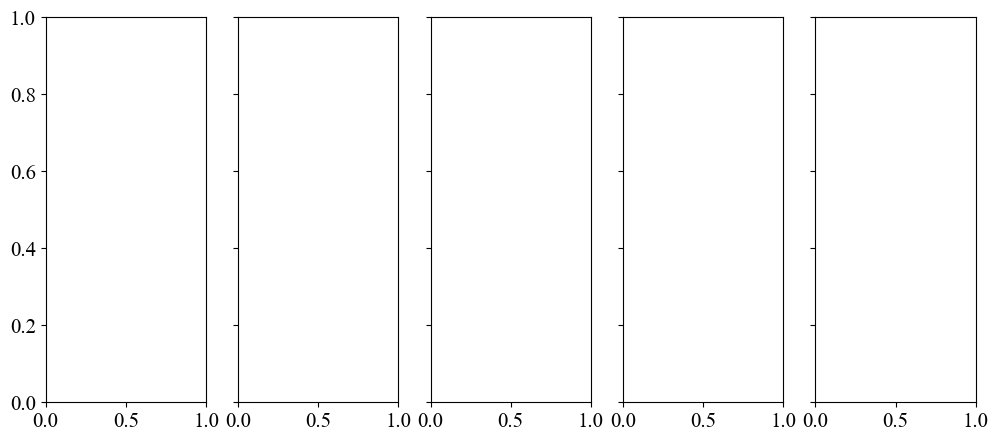

In [34]:
# Define sigma, a small number is usually the best choice
sigma=1 # (or 2 at most)

fig, ax = plt.subplots(1, len(batch_size_range), figsize=(12,5), sharey=True)
for i,bs in enumerate(batch_size_range):    
    dz_means, dz_stds = [], []
    dz_train_means, dz_train_stds = [], []
    for dz in range(1, params['max_dz']+1):
        mi_trials = []
        mi_train = []
        for j in range(params['n_trials']):
            key = f"trial_{j}_dz_{dz}_bs_{bs}"
            # Convert Nan to zeros and smooth
            # test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma) / bs * np.log2(np.e) * 1000
            train = gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma) * np.log2(np.e) #/ (0.0005 * bs)
            test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma) * np.log2(np.e) #/ (0.0005 * bs)
            # Pick the epoch with highest test value and get corresponding train
            best = np.argmax(test)
            mi_trials.append(test[best])
            mi_train.append(train[best])
        dz_means.append(np.mean(np.array(mi_trials)).flatten())
        dz_stds.append(np.std(np.array(mi_trials)).flatten())
        dz_train_means.append(np.mean(np.array(mi_train)).flatten())
        dz_train_stds.append(np.std(np.array(mi_train)).flatten())
    b = ax[i].errorbar(
        range(1, params['max_dz']+1), np.array(dz_means).flatten(), 
        yerr=np.array(dz_stds).flatten(), 
        fmt='s:', capsize=4)
    # ax[i].errorbar(
    #     range(1, params['max_dz']+1), np.array(dz_train_means).flatten(), 
    #     yerr=np.array(dz_train_stds).flatten(), 
    #     fmt='s:', capsize=4)

    # Set title and scales
    ax[i].set_title(str(bs))
    ax[i].set_xlabel(r'$dz$')
    if i == 0:
        ax[i].set_ylabel(r'$I(X;Y) \text{(bits/s)}$');
    # ax[i].set_ylim(-1, 4)


trial_0_dz_10_bs_64


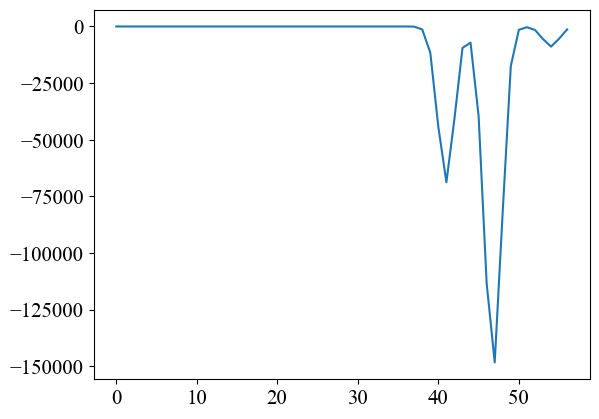

In [72]:
key = random.choice(list(mi_test.keys()))
sigma = 1
# plt.plot(gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma))
plt.plot(gaussian_filter1d(np.nan_to_num(mi_test[key]) * np.log2(np.e), sigma=sigma))
# plt.gca().set_ylim(0)
print(key)

In [82]:
import pickle

with open(os.path.join(main_dir, 'mi_test_2025-04-27.pkl'), 'wb') as f:
    pickle.dump(mi_test, f)
with open(os.path.join(main_dir, 'ids_2025-04-27.pkl'), 'wb') as f:
    pickle.dump(ids, f)


In [91]:
ids

{'trial_0_dz_5_bs_64': 'DSIB_dz-5_bs-64_8fd6f693-0e8c-4050-80f0-71743727faf4',
 'trial_1_dz_5_bs_64': 'DSIB_dz-5_bs-64_53c1ac4c-c23f-4fb7-b0de-03609854555d',
 'trial_2_dz_5_bs_64': 'DSIB_dz-5_bs-64_980c7b88-ae7e-45c8-8654-43988f324259',
 'trial_0_dz_6_bs_64': 'DSIB_dz-6_bs-64_f5780180-bfd3-435e-b811-ea7695d4a1b5',
 'trial_1_dz_6_bs_64': 'DSIB_dz-6_bs-64_bd177624-0f1d-47e3-9b66-3efe1affcb26',
 'trial_2_dz_6_bs_64': 'DSIB_dz-6_bs-64_e444d9e9-1f41-4509-8b87-95f2bcb4c6ba',
 'trial_0_dz_7_bs_64': 'DSIB_dz-7_bs-64_9dc5f773-c58a-41b1-8d58-f154bc18fe83',
 'trial_1_dz_7_bs_64': 'DSIB_dz-7_bs-64_136f4efa-0772-4a42-b8d1-163fcca65eda',
 'trial_2_dz_7_bs_64': 'DSIB_dz-7_bs-64_aa666a3e-dd74-47c8-9e75-a2260fe347af',
 'trial_0_dz_8_bs_64': 'DSIB_dz-8_bs-64_aaf1e6a7-8d80-4aba-bfe0-8fc840cb522f',
 'trial_1_dz_8_bs_64': 'DSIB_dz-8_bs-64_ef96a2d7-2bcc-45d7-b9ec-20ad29bfc0a7',
 'trial_2_dz_8_bs_64': 'DSIB_dz-8_bs-64_b53fd0ff-c038-4b42-b96d-2a9a32ea69e8',
 'trial_0_dz_9_bs_64': 'DSIB_dz-9_bs-64_6ce81eb9-0f7

In [ ]:
with open(os.path.join(main_dir, 'mi_test_2025-04-27.pkl'), 'rb') as f:
    bob = pickle.load(f)
with open(os.path.join(main_dir, 'ids_2025-04-27.pkl'), 'rb') as f:
    bob = pickle.load(f)

Okay, so running on the whole dataset takes a long time. 


Scheme for a given moth:
- X embedding dimension sizes
- Y repeats at each embedding dim size
- Z batch sizes